### **Artefact Detection**

This notebook plots the predictions of the model->  FasterRCNN, *ref* : https://arxiv.org/abs/1506.01497. Faster R-CNN is a single-stage model that is trained end-to-end. It uses a novel region proposal network (RPN) for generating region proposals, which save time compared to traditional algorithms like Selective Search. It uses the ROI Pooling layer to extract a fixed-length feature vector from each region proposal.The network can accurately and quickly predict the locations of different objects. Please refer to [Faster R-CNN Explained for Object Detection Tasks](https://https://blog.paperspace.com/faster-r-cnn-explained-object-detection/) for a quick introduction.
 With this notebook, you will be able to detect: QR Codes, Bar codes, Company logos & Photos at the moment.  

Installing requirements


In [ ]:
!pip3 install git+https://github.com/mindee/doctr.git

Import all dependencies at once 

In [2]:
import os

os.environ['USE_TORCH'] = '1'

import argparse
import logging

import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch

from doctr.io.image import read_img_as_tensor
from doctr.models import obj_detection

# Detected classes
CLASSES = ["__background__", "QR Code", "Barcode", "Logo", "Photo"]
# Color map for each class
CM = [(255, 255, 255), (0, 0, 150), (0, 0, 0), (0, 150, 0), (150, 0, 0)]

Everything you need to plot your model's predictions

In [3]:
# Plots the predictions on the input image
def plot_predictions(image, boxes, labels):
    for box, label in zip(boxes, labels):
        # Bounding box around artefacts
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]),
                      CM[label], 2)
        text_size, _ = cv2.getTextSize(CLASSES[label], cv2.FONT_HERSHEY_SIMPLEX, 2, 2)
        text_w, text_h = text_size
        # Filled rectangle above bounding box
        cv2.rectangle(image, (box[0], box[1]), (box[0] + text_w, box[1] - text_h),
                      CM[label], -1)
        # Text bearing the name of the artefact detected
        cv2.putText(image, CLASSES[label], (int(box[0]), int(box[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    figure(figsize=(10, 8), dpi=90)
    plt.axis('off')
    plt.imshow(image)
    plt.show()



`img_path: str` >> path to image file


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



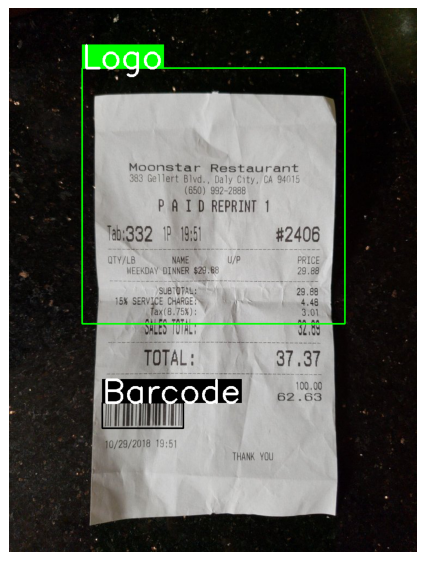

In [4]:
# Initializing the model fasterrcnn_mobilenet_v3_large_fpn
model = obj_detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, num_classes=5).eval()
# Path to input image file
img_path = "/content/drive/MyDrive/colab/1022-receipt.jpg"
# Reading the input image
img = read_img_as_tensor(img_path).unsqueeze(0)

if torch.cuda.is_available():
    model = model.cuda()
    img = img.cuda()

with torch.no_grad():
    pred = model(img)

labels = pred[0]['labels'].detach().cpu().numpy()
labels = labels.round().astype(int)
boxes = pred[0]['boxes'].detach().cpu().numpy()
boxes = boxes.round().astype(int)
img = img.cpu().permute(0, 2, 3, 1).numpy()[0].copy()
plot_predictions(img, boxes, labels)